In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.4/982.4 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

***Imports & Common Settings :***

In [2]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

#class IDs from the COCO dataset
person_id = 0
bottle_id = 39
cup_id = 41

#calculate Intersection Over Union (IOU) between two bounding boxes
def iou(box_a, box_b):
    x_a = max(box_a[0], box_b[0])
    y_a = max(box_a[1], box_b[1])
    x_b = min(box_a[2], box_b[2])
    y_b = min(box_a[3], box_b[3])

    # Calculate area of the intersection rectangle
    inter_area = max(0, x_b - x_a) * max(0, y_b - y_a)
    if inter_area== 0:
        return 0.0

    # Calculate the area of both bounding boxes
    box_a_area = (box_a[2] - box_a[0]) * (box_a[3] - box_a[1])
    box_b_area = (box_b[2] - box_b[0]) * (box_b[3] - box_b[1])

    # Calculate the IOU = intersection area / union area
    return inter_area / float(box_a_area + box_b_area - inter_area)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


***Image Detection & Annotation :***


image 1/1 /content/Input_Image/image.png: 640x448 4 persons, 2 bottles, 2 cups, 1143.4ms
Speed: 3.5ms preprocess, 1143.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)


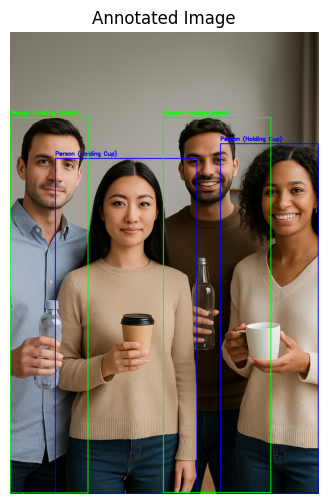

Annotated image saved to: /content/Output_Image/Annotated_Image.jpg


In [6]:
model = YOLO('yolov8m.pt')

image_path = '/content/Input_Image/image.png'

results = model(image_path)

# Extract bounding boxes and class IDs for detected objects
boxes = results[0].boxes.xyxy.cpu().numpy()

class_ids = results[0].boxes.cls.cpu().numpy()

# Filter detected objects by class (Person, Bottle, Cup)
persons = []
bottles = []
cups = []

for i in range(len(class_ids)):
    if int(class_ids[i]) == person_id:
          persons.append(boxes[i])
    elif int(class_ids[i]) == bottle_id:
          bottles.append(boxes[i])
    elif int(class_ids[i]) == cup_id:
          cups.append(boxes[i])

img = cv2.imread(image_path)

# Check each person to see if they're holding a bottle or cup
for person_box in persons:
    best_iou = 0
    best_obj = None
    obj_type = None

   # Compare person with each bottle and cup
    for obj_box in bottles + cups:
        score = iou(person_box, obj_box)
        if score > 0.01 and score > best_iou:
            best_iou = score
            best_obj = obj_box
            obj_type = 'cup' if any(np.array_equal(obj_box, c) for c in cups) else 'bottle'

    #Draw annotation if cup/bottle near the person
    if best_obj is not None:
        x1, y1, x2, y2 = map(int, person_box)
        color = (255, 0, 0) if obj_type == 'cup' else (0, 255, 0)
        label = f"Person (Holding {obj_type.capitalize()})"

        # Draw bounding box and label on the image
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, label, (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)


output_path = '/content/Output_Image/Annotated_Image.jpg'
cv2.imwrite(output_path, img)

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Annotated Image')
plt.show()

print(f"Annotated image saved to: {output_path}")


***Video Detection & Annotation :***

In [7]:
video_path = '/content/Input_Video/videoplayback.mp4'
cap = cv2.VideoCapture(video_path)


fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out_path = '/content/Output_Video/Annotated_video.mp4'
fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

# Process the video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    results = model(frame)

    # Extract bounding boxes and class IDs for detected objects
    boxes = results[0].boxes.xyxy.cpu().numpy()
    class_ids = results[0].boxes.cls.cpu().numpy()

    # Filter detected objects by class (Person, Bottle, Cup)
    persons = []
    bottles = []
    cups = []

    for i in range(len(class_ids)):
          if int(class_ids[i]) == person_id:
                 persons.append(boxes[i])
          elif int(class_ids[i]) == bottle_id:
                 bottles.append(boxes[i])
          elif int(class_ids[i]) == cup_id:
                 cups.append(boxes[i])


    # Check each person to see if they're holding a bottle or cup
    for person_box in persons:
        best_iou = 0
        best_obj = None
        obj_type = None

        # Compare person with each bottle and cup
        for obj_box in bottles + cups:
            score = iou(person_box, obj_box)
            if score > 0.01 and score > best_iou:
                best_iou = score
                best_obj = obj_box
                obj_type = 'cup' if any(np.array_equal(obj_box, c) for c in cups) else 'bottle'

        #Draw annotation if cup/bottle near the person
        if best_obj is not None:
            x1, y1, x2, y2 = map(int, person_box)
            color = (255, 0, 0) if obj_type == 'cup' else (0, 255, 0)
            label = f"Person (Holding {obj_type.capitalize()})"

             # Draw bounding box and label on the frame
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)


    out.write(frame)


cap.release()
out.release()
print(f"Annotated video saved to: {out_path}")



0: 640x384 1 person, 1 bottle, 1013.6ms
Speed: 8.1ms preprocess, 1013.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 bottle, 947.4ms
Speed: 3.6ms preprocess, 947.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 bottle, 942.4ms
Speed: 2.4ms preprocess, 942.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 bottle, 999.9ms
Speed: 3.3ms preprocess, 999.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 bottle, 1082.6ms
Speed: 2.6ms preprocess, 1082.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 bottle, 1529.3ms
Speed: 3.0ms preprocess, 1529.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 bottle, 1422.8ms
Speed: 2.4ms preprocess, 1422.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 bo